### Imports

In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.prepared import prep
from shapely.ops import split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from tqdm.auto import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


### Load files

In [2]:
gis_path = "~/data/gis/vector/"
ibtracs_load = pd.read_csv(gis_path+"/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])

In [3]:
print(ibtracs_load.columns.tolist())

['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME', 'NATURE', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'WMO_AGENCY', 'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'IFLAG', 'USA_AGENCY', 'USA_ATCF_ID', 'USA_LAT', 'USA_LON', 'USA_RECORD', 'USA_STATUS', 'USA_WIND', 'USA_PRES', 'USA_SSHS', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW', 'USA_POCI', 'USA_ROCI', 'USA_RMW', 'USA_EYE', 'TOKYO_LAT', 'TOKYO_LON', 'TOKYO_GRADE', 'TOKYO_WIND', 'TOKYO_PRES', 'TOKYO_R50_DIR', 'TOKYO_R50_LONG', 'TOKYO_R50_SHORT', 'TOKYO_R30_DIR', 'TOKYO_R30_LONG', 'TOKYO_R30_SHORT', 'TOKYO_LAND', 'CMA_LAT', 'CMA_LON', 'CMA_CAT', 'CMA_WIND', 'CMA_PRES', 'HKO_LAT', 'HKO_LON', 'HKO_CAT', 'HKO_WIND', 'HKO_PRES', 'KMA_LAT', 'KMA_LON', 'KMA_CAT', 'KMA_WIND', 'KMA_PRES', 'KMA_R50_DIR', 'KMA_R50_LONG', 'KMA_R50_SHORT', 'KMA_R30_DIR', 'KMA_R30_LONG', 'KMA_R30_SHORT', 'NEWDELHI_LAT', 'NEWDELHI_LON', 'N

In [4]:
keep_cols = ["SID", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "STORM_SPEED", "STORM_DIR"]
ibtracs = ibtracs_load[keep_cols].copy()
ibtracs["ISO_TIME"] = pd.to_datetime(ibtracs["ISO_TIME"], errors="coerce")

In [5]:
# Convert to GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(
    ibtracs,
    geometry=gpd.points_from_xy(ibtracs["LON"], ibtracs["LAT"]),
    crs="EPSG:4326"
)

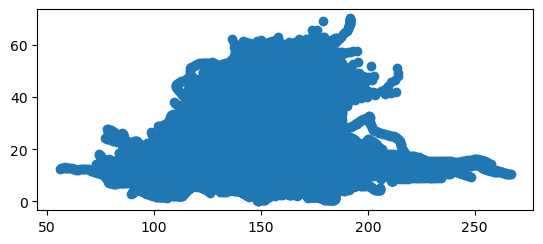

In [6]:
gdf_tracks.plot()
plt.show()

In [7]:
print(gdf_tracks.columns.tolist())

['SID', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_SPEED', 'STORM_DIR', 'geometry']


In [8]:
gdf_coast  = gpd.read_file("ph-coast.gpkg").to_crs(4326)
gdf_waters = gpd.read_file("ph-waters.gpkg").to_crs(4326)
gdf_par    = gpd.read_file("ph-par.gpkg").to_crs(4326)

gdf_waters_shape = gdf_waters.geometry.iloc[0]
gdf_par_shape = gdf_par.geometry[0]

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-bbr/.conda/envs/ibtracs-wp-preprocess/share/proj failed


### Calculate TC Intersections

In [9]:
ph_prepared = prep(gdf_waters.geometry[0])
par_prepared = prep(gdf_par.geometry[0])

# Also get their bounding boxes for a fast first filter
ph_bounds = gdf_waters_shape.bounds
par_bounds = gdf_par_shape.bounds

intersect_results = []

for sid, group in tqdm(gdf_tracks.groupby("SID")):
    points = list(group.sort_values("ISO_TIME")["geometry"])
    if len(points) < 2:
        continue  # Skip storms with insufficient points

    track_line = LineString(points)
    line_bounds = track_line.bounds

    # Fast bounding box skip
    skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
              (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])

    skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
               (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])

    # Use prepped geometry for faster intersects
    intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
    intersects_par = False if skip_par else par_prepared.intersects(track_line)

    intersect_results.append({
        "SID": sid,
        "intersects_ph": intersects_ph,
        "intersects_par": intersects_par
    })

# Wrap in DataFrame
df_intersects = pd.DataFrame(intersect_results)

# Final counts
n_track_in_ph = df_intersects["intersects_ph"].sum()
n_track_in_par = df_intersects["intersects_par"].sum()

print(f"{n_track_in_ph} TCs intersected PH.")
print(f"{n_track_in_par} TCs intersected PAR.")


  0%|          | 0/4187 [00:00<?, ?it/s]

1183 TCs intersected PH.
2817 TCs intersected PAR.


In [10]:
gdf_tracks = gdf_tracks.merge(
    df_intersects,
    on="SID",
    how="left"
)


In [11]:
gdf_tracks.head()

,SID,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES,STORM_SPEED,STORM_DIR,geometry,intersects_ph,intersects_par
0,1884177N17124,1884-06-24 16:00:00,16.5,124.0,,,6,280,POINT (124 16.5),True,True
1,1884177N17124,1884-06-24 18:00:00,16.5,123.8,,,6,280,POINT (123.8 16.5),True,True
2,1884177N17124,1884-06-24 21:00:00,16.6,123.5,,,6,285,POINT (123.5 16.6),True,True
3,1884177N17124,1884-06-25 00:00:00,16.7,123.2,,,6,285,POINT (123.2 16.7),True,True
4,1884177N17124,1884-06-25 03:00:00,16.8,122.9,,,6,290,POINT (122.9 16.8),True,True


In [12]:
# After converting ISO_TIME to datetime:
gdf_tracks["hour"] = gdf_tracks["ISO_TIME"].dt.hour

# Keep only rows where hour is in [0, 6, 12, 18]:
gdf_tracks = gdf_tracks[gdf_tracks["hour"].isin([0, 6, 12, 18])].copy()
gdf_tracks.drop(columns=["hour"], inplace=True)


In [13]:
gdf_tracks

,SID,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES,STORM_SPEED,STORM_DIR,geometry,intersects_ph,intersects_par
1,1884177N17124,1884-06-24 18:00:00,16.5,123.8,,,6,280,POINT (123.8 16.5),True,True
3,1884177N17124,1884-06-25 00:00:00,16.7,123.2,,,6,285,POINT (123.2 16.7),True,True
6,1884177N17124,1884-06-25 06:00:00,16.9,122.6,,,6,295,POINT (122.6 16.9),True,True
8,1884177N17124,1884-06-25 12:00:00,17.2,122.0,,,7,300,POINT (122 17.2),True,True
11,1884177N17124,1884-06-25 18:00:00,17.5,121.4,,,7,295,POINT (121.4 17.5),True,True
...,...,...,...,...,...,...,...,...,...,...,...
245109,2024358N10113,2024-12-25 00:00:00,10.5,110.8,,,10,215,POINT (110.8 10.5),False,False
245111,2024358N10113,2024-12-25 06:00:00,9.6,110.3,,,7,205,POINT (110.3 9.6),False,False
245113,2024358N10113,2024-12-25 12:00:00,9.3,110.1,,,6,225,POINT (110.1 9.3),False,False
245115,2024358N10113,2024-12-25 18:00:00,8.7,109.3,,,10,255,POINT (109.3 8.7),False,False


In [14]:
gdf_tracks.to_feather("gdf_tracks.feather")


In [15]:
df_tracks = gdf_tracks.drop(columns=["geometry"]).copy()
df_tracks.to_parquet("ibtracs_wp_tracks.parquet")
